# Viz - RF Casual

In [1]:
%matplotlib inline

from util_functions import *
import numpy as np
import pandas as pd
from pprint import pprint
import time
import matplotlib.pyplot as plt
import seaborn as sns

start_time = time.perf_counter()

set_env_path()
conn, cur = aws_connect()

query = """
SELECT 
EXTRACT(DOY FROM date) as day_of_year,
date,
year,
quarter,
month,
CASE WHEN day_of_week = any('{0,6}') THEN 1 ELSE 0 END as weekend_dummy,
daylight_hours,
apparenttemperaturehigh,
apparenttemperaturehightime,
apparenttemperaturelow,
apparenttemperaturelowtime,
precipintensitymaxtime,
sunrisetime,
sunsettime,
cloudcover,
dewpoint,
humidity,
precipaccumulation,
precipintensitymax,
precipprobability,
rain,
snow,
visibility,
windspeed,
us_holiday,
nats_single,
nats_double,
nats_attendance,
dc_bike_event,
dc_pop,
cabi_bikes_avail,
cabi_stations_alx,
cabi_stations_arl,
cabi_stations_ffx,
cabi_stations_mcn,
cabi_stations_mcs,
cabi_stations_wdc,
cabi_docks_alx,
cabi_docks_arl,
cabi_docks_ffx,
cabi_docks_mcn,
cabi_docks_mcs,
cabi_docks_wdc,
cabi_stations_tot,
cabi_docks_tot,
cabi_active_members_day_key,
cabi_active_members_monthly,
cabi_active_members_annual,
cabi_trips_wdc_to_wdc,
cabi_trips_wdc_to_wdc_casual,
dless_trips_all
from final_db"""

pd.options.display.max_rows = None
pd.options.display.max_columns = None

df = pd.read_sql(query, con=conn)

# Setting date to index for easier splitting
df.set_index(df.date, drop=True, inplace=True)
df.index = pd.to_datetime(df.index)

df['sin_day_of_year'] = np.sin(2*np.pi*df.day_of_year/365)
df['cos_day_of_year'] = np.cos(2*np.pi*df.day_of_year/365)

train = df.loc['2013-01-01':'2017-09-08']
test = df.loc['2017-09-09':'2018-04-30']

# Specify columns to keep and drop for X and y
drop_cols = ['date', 'dless_trips_all']
y_cols = ['cabi_trips_wdc_to_wdc', 'cabi_trips_wdc_to_wdc_casual']

feature_cols = [col for col in df.columns if (col not in y_cols) & (col not in drop_cols)]

# X y split
Xtrain = train[feature_cols]

# Our target variable here is casual DC to DC trips
ytrain = train[y_cols[1]]
Xtest = test[feature_cols]
ytest = test[y_cols[1]]
print(Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape)

# Pull out dockless trips
dless = test['dless_trips_all']

(1712, 49) (1712,) (234, 49) (234,)


In [2]:
from sklearn.externals import joblib

rf = joblib.load('rf_casual.pkl') 

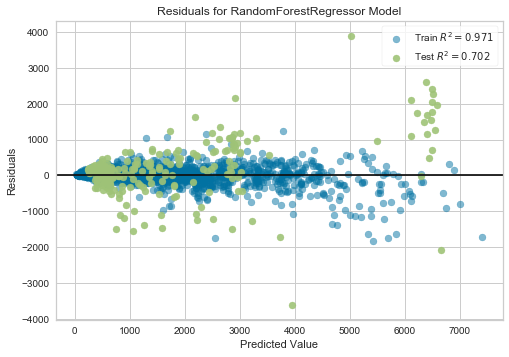

In [3]:
from yellowbrick.regressor import ResidualsPlot

resplot = ResidualsPlot(rf)

resplot.fit(Xtrain, ytrain)
resplot.score(Xtest, ytest)
g = resplot.poof()

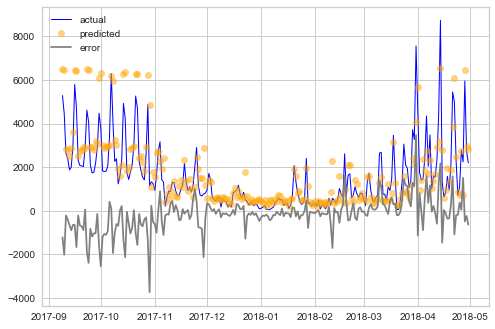

In [4]:
rf.fit(Xtrain, ytrain)

yhat = rf.predict(Xtest)
error = ytest - yhat

data = pd.DataFrame({'t': test['date'], 
                     'ytest': ytest, 
                     'yhat': yhat,
                     'error': error,
                     'neg_error': np.negative(error),
                     'dless': dless})

plt.plot('t', 'ytest', data=data, color='blue', linewidth=1, label='actual')
plt.plot('t', 'yhat', data=data, color='orange', marker='o', linestyle="None", label='predicted', alpha=0.5)
plt.plot('t', 'error', data=data, color='gray')
plt.legend()
plt.show()

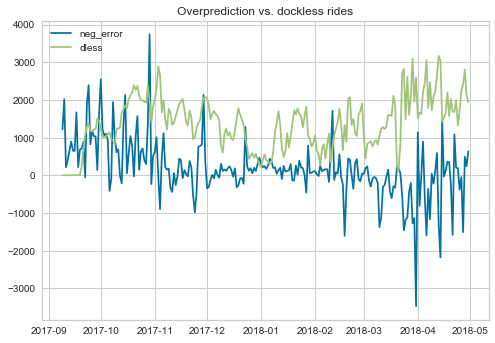

In [5]:
# Negative error is the amount our model overpredicted by (predicted - actual)
plt.plot('t', 'neg_error', data=data)
plt.plot('t', 'dless', data=data)
plt.title('Overprediction vs. dockless rides')
plt.legend()

In [6]:
print(data.head(10))

# Atypical dockless data before 9/20 so we can cut off there for graphing purposes
data = data.loc['2017-09-20':]

data.head()

            dless        error    neg_error           t         yhat   ytest
date                                                                        
2017-09-09    0.0 -1219.088087  1219.088087  2017-09-09  6503.088087  5284.0
2017-09-10    2.0 -2019.299301  2019.299301  2017-09-10  6470.299301  4451.0
2017-09-11    3.0  -214.758076   214.758076  2017-09-11  2833.758076  2619.0
2017-09-12    2.0  -407.794371   407.794371  2017-09-12  2805.794371  2398.0
2017-09-13    0.0  -654.590997   654.590997  2017-09-13  2524.590997  1870.0
2017-09-14    3.0  -896.069459   896.069459  2017-09-14  2888.069459  1992.0
2017-09-15    3.0  -649.286800   649.286800  2017-09-15  3615.286800  2966.0
2017-09-16    8.0  -649.324921   649.324921  2017-09-16  6444.324921  5795.0
2017-09-17    3.0 -1668.407424  1668.407424  2017-09-17  6403.407424  4735.0
2017-09-18    3.0  -215.517242   215.517242  2017-09-18  2520.517242  2305.0


,dless,error,neg_error,t,yhat,ytest
date,,,,,,
2017-09-20,237.0,-711.984527,711.984527,2017-09-20,2768.984527,2057.0
2017-09-21,706.0,-885.189164,885.189164,2017-09-21,2913.189164,2028.0
2017-09-22,1068.0,53.592557,-53.592557,2017-09-22,2873.407443,2927.0
2017-09-23,1287.0,-1890.954399,1890.954399,2017-09-23,6504.954399,4614.0
2017-09-24,1373.0,-2390.386264,2390.386264,2017-09-24,6470.386264,4080.0


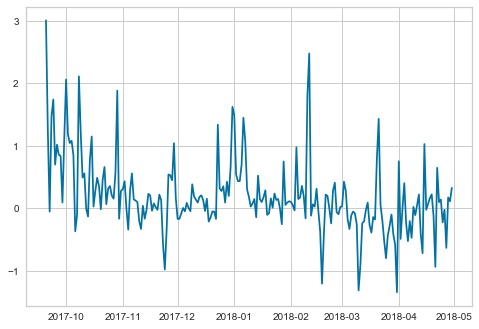

In [7]:
data['dless_impact'] = data['neg_error']/data['dless']
plt.plot('t', 'dless_impact', data=data)

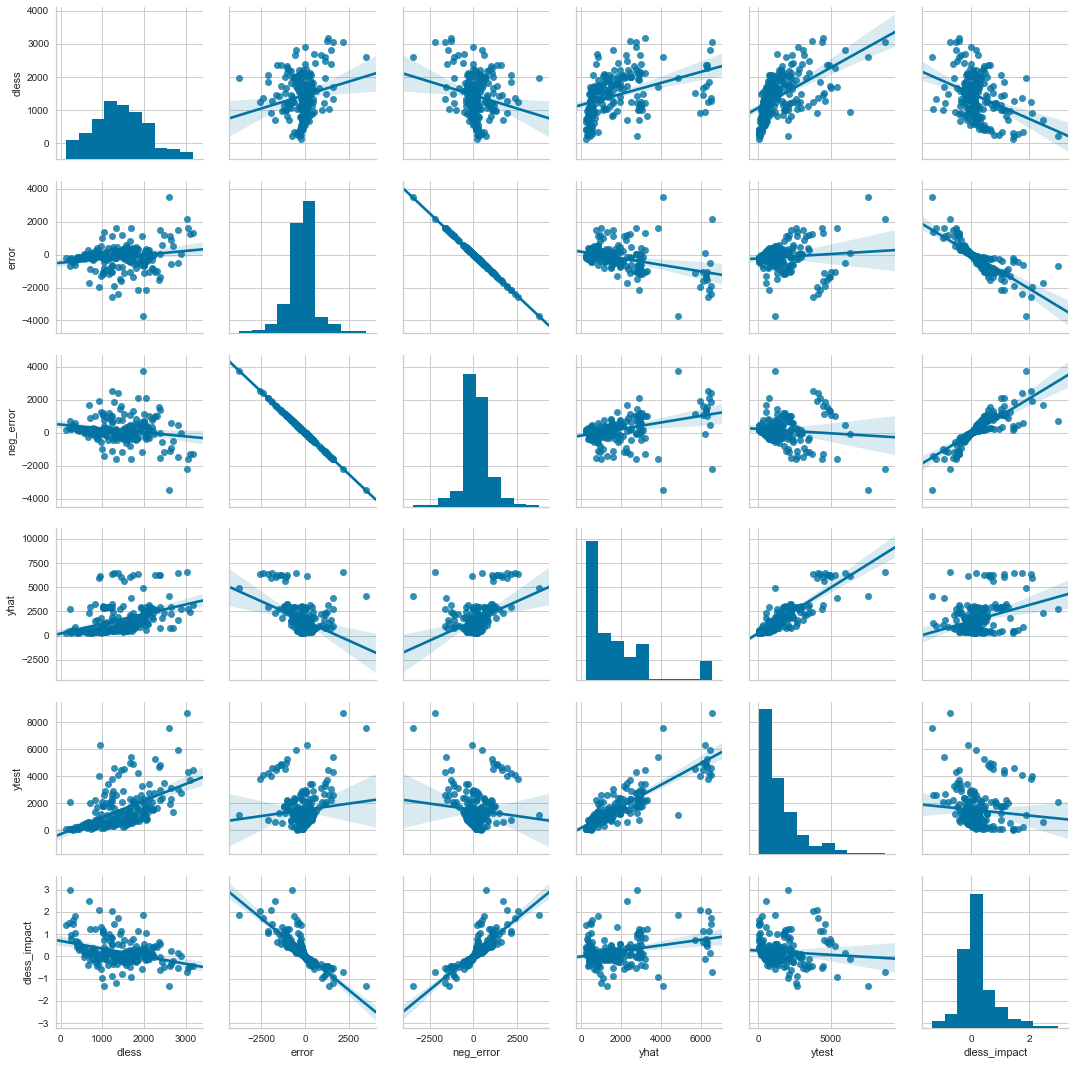

In [8]:
sns.pairplot(data, kind='reg')

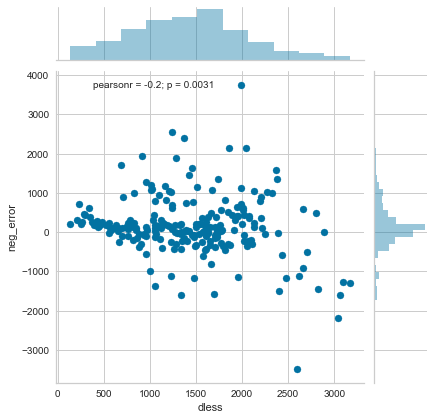

In [9]:
sns.jointplot('dless', 'neg_error', data=data)

In [10]:
data.to_csv('rf_casual.csv')